<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#SKLearn" data-toc-modified-id="SKLearn-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SKLearn</a></span></li><li><span><a href="#Boosting" data-toc-modified-id="Boosting-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Boosting</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BERT</a></span><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

импорты

In [1]:
import sys
import time
import re
import warnings
import torch
import transformers
from tqdm import (
    notebook,
    tqdm
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import(
    wordnet, 
    stopwords as nltk_stopwords
)
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)
from sklearn.model_selection import (
    KFold,
    train_test_split, 
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')
pd.set_option("display.float_format", lambda x: "%.4f" % x)

RS = 17

чтение

сразу сделаем копию датасета для Берта с 1000 семплами, т.к. исходный датасет будет преобразован с помощью сторонных модулей предобработки данных

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

df_bert = df.copy().sample(1000).reset_index(drop=True)

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


загрузим пакет stopwords со списком стоп-слов, вызовем функцию stopwords.words(), передадим ей аргумент 'english', т.к. корпус тестов на английском

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
# для пос-тегов
# nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uber4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\uber4\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


объявим функцию, внутри нее произведем очистку текстов регулярными выражениями, токенизацию, лемматизацию, и на выходе получим преобразованный корпус текстов

In [4]:
tqdm.pandas()

lem = nltk.WordNetLemmatizer()

# с пос-тегами значение метрики варьируется в тысячных долях в разные стороны для разных моделей, поэтому смысла в них нет
# def get_wordnet_pos(word):
    
#     tag = nltk.pos_tag([word])[0][1][0]
#     tag_dict = {"J": 'a',
#                 "N": 'n',
#                 "V": 'v',
#                 "R": 'r'}
#     return tag_dict.get(tag, wordnet.NOUN)

def lemmatized_clear_text(text):
    
    text = re.sub('[0-9]+', ' ', text.lower())
    text = re.sub(r'^[a-zA-Z]+', ' ', text.lower())
    text = re.split('\W+', text)
    
    # lem.lemmatize(x, get_wordnet_pos(x)) для pos-teg
    text = ' '.join([lem.lemmatize(x) for x in text if x not in stopwords]) 
    return text
    
df['text'] = df['text'].progress_apply(lemmatized_clear_text)

# для преобразованного датасета с пос-тегами
#df['text'].to_csv('df_text_lemmatized')

df.head()

100%|██████████| 159292/159292 [01:04<00:00, 2465.73it/s]


,text,toxic
0,edits made username hardcore metallica fan re...,0
1,aww match background colour seemingly stuck t...,0
2,man really trying edit war guy constantly rem...,0
3,make real suggestion improvement wondered sec...,0
4,sir hero chance remember page,0


разделим данные на трейн и тест

In [5]:
X, X_test, y, y_test = train_test_split(
    df['text'],
    df['toxic'],
    test_size=.25,
    stratify=df['toxic'],
    random_state=RS)

проверим баланс класов

----------------------------------------
отношение классов 143106:16186
                     8.8:1
----------------------------------------


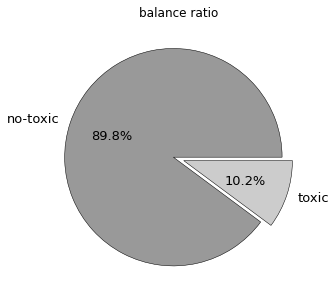

In [6]:
df['toxic'].value_counts().plot(
    kind='pie',
    title='balance ratio',
    ylabel='',
    labels=['no-toxic','toxic'],
    autopct='%.1f%%',
    explode=[0.05,0.05],
    figsize=(5,5),
    fontsize=13,
    wedgeprops = {'linewidth':0.5,'edgecolor':'k'},
    colors=['0.6','0.8']
    
);
print('-'*40)
print(f'отношение классов {df["toxic"].value_counts()[0]}:{df["toxic"].value_counts()[1]}')
print(' '*20,f'{df["toxic"].value_counts()[0]/df["toxic"].value_counts()[1]:.1f}:1')
print('-'*40)

выявлен дисбаланс классов с большим весом у класса 0 почти в 9 раз.есть 3 способа устранения дисбаласна: задать для модели параметр class_weight, downsampled, upsampled. 2ой и 3ий методы пропускаем ввиду необходимости подключения дополнительных модулей типа SMOTE и Imblearn для корректного отображения метрик после кросс-валидации по причине переобучения моделей, оставляем первый вариант, как простой в эксплуатации и эффективный с точки зрения его эксплуатации в ранних проектах. еще стоит учесть, что борьба с дисбалансом с помощью семплирования не единственный метод, подбор модели и ее параметров даст результат лучше. поэтому балансировку произведем только для линеных моделей

**Вывод по подготовке данных:**

- загружены данные, импорты, пакеты для работы с тестовыми данными на английском языке;
- данные токенизированы, лемматизированны, очищены, разбиты на выборки;
- выборки преобразованы для обучения моделей разными методами.

Данные готовы к обучению.

## Обучение

Обучим модели sklearn (логистическая регрессия) и бустинга (lgbm) с помощью pipeline и cv

In [7]:
def classifier_cv(model, params):
    
    classifier = RandomizedSearchCV(
         model, 
         params, 
         cv = KFold(5, shuffle=True, random_state=RS),
         scoring = 'f1',
         n_jobs = -1,
         verbose = 10
    )
    classifier.fit(X, y)
    
    f1_cv = classifier.best_score_.round(4)  
    best_params = classifier.best_params_
    best_model = classifier.best_estimator_
    
    return f1_cv, best_params, best_model

### SKLearn

**Logistic Regression Tf-Idf**

In [8]:
%%time
pipe_lr_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(class_weight='balanced',random_state=RS))
])
params_lr = {
    'logreg__solver':['liblinear'],
    'logreg__C': [10]
}
lr_tfidf_f1_cv, lr_tfidf_best_params, lr_tfidf_best_model = classifier_cv(
    pipe_lr_tfidf, 
    params_lr
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 25.6 s
Wall time: 36.5 s


**Logistic Regression Bow**

In [9]:
%%time
pipe_lr_bow = Pipeline([
    ('bow', CountVectorizer()),
    ('logreg', LogisticRegression(class_weight='balanced',random_state=RS))
])
params_lr_bow = {
    'logreg__solver':['lbfgs'],
    'logreg__C': [1]
}
lr_bow_f1_cv, lr_bow_best_params, lr_bow_best_model = classifier_cv(
    pipe_lr_bow, 
    params_lr_bow
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 38.6 s
Wall time: 40.2 s


### Boosting

**LightGBM Classifier Tf-Idf**

In [10]:
%%time
pipe_lgbm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgbm', LGBMClassifier(random_state=RS))
])
params_lgbm_tfidf = {
    'lgbm__n_estimators':[500],
    'lgbm__learning_rate':[0.1],
    'lgbm__max_depth':[50]
}
lgbm_tfidf_f1_cv, lgbm_tfidf_best_params, lgbm_tfidf_best_model = classifier_cv(
    pipe_lgbm_tfidf, 
    params_lgbm_tfidf
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 9min 13s
Wall time: 7min 4s


**LightGBM Classifier Bow**

In [11]:
%%time
pipe_lgbm_bow = Pipeline([
    ('bow', CountVectorizer(dtype='float')),
    ('lgbm', LGBMClassifier(random_state=RS)),
])
params_lgbm_bow = {
    'lgbm__n_estimators':[500],
    'lgbm__learning_rate':[0.1],
    'lgbm__max_depth':[50]
}
lgbm_bow_f1_cv, lgbm_bow_best_params, lgbm_bow_best_model = classifier_cv(
    pipe_lgbm_bow, 
    params_lgbm_bow
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 2min 29s
Wall time: 2min 30s


выведем результаты

In [12]:
print()
print('*'*14,'F1 CV ML','*'*14)
pd.DataFrame({
     'Logistic Regression':[lr_tfidf_f1_cv,
                           lr_bow_f1_cv],
     'LightGBM Classifier':[lgbm_tfidf_f1_cv,
                            lgbm_bow_f1_cv]
     },
     index=['Tf-Ifd',
           'Bow']
)


************** F1 CV ML **************


,Logistic Regression,LightGBM Classifier
Tf-Ifd,0.7526,0.7657
Bow,0.7441,0.7623


проведем тест для модели с лучшим значением метрики

In [13]:
lgbm_tfidf_f1_test = f1_score(
    y_test, lgbm_tfidf_best_model.predict(X_test)).round(4)

print()
print('*'*5,'F1 LGBM TF-IFD','*'*5)
print()
pd.DataFrame({
     'LightGBM Classifier':[lgbm_tfidf_f1_cv,
                            lgbm_tfidf_f1_test]
     },
     index=['f1 train',
            'f1 test']
)


***** F1 LGBM TF-IFD *****



,LightGBM Classifier
f1 train,0.7657
f1 test,0.7764


удалим ненужные переменные для оптимизации памяти и ресурсов платформы

In [14]:
del X
del X_test
del y
del y_test

## BERT

### Подготовка

датасет для Берта был создан в начале проекта, используем Toxic Bert

In [15]:
tqdm.pandas()

tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert', config=config)

tokenized = df_bert['text'].progress_apply(
lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True)) 

padded = pad_sequence([torch.as_tensor(seq) for seq in tokenized], batch_first=True)  

attention_mask = padded > 0
attention_mask = attention_mask.type(torch.LongTensor)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [00:03<00:00, 299.91it/s]


In [16]:
batch_size = 5
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

features = np.concatenate(embeddings)
np.save('embeddings', features)

  0%|          | 0/200 [00:00<?, ?it/s]

батчи готовы и преобразованы в признаки для обучения, подготовим данные для обучения

In [17]:
X, X_test, y, y_test = train_test_split(
    features, 
    df_bert['toxic'], 
    test_size=.25,
    stratify=df_bert['toxic'],
    random_state=RS
)
print('Размеры выборок для метода BERT')
print('-'*35)
print(f'размер трейна {X.shape} -- таргета на трейне {y.shape}')
print('-'*50)
print(f'размер теста   {X_test.shape} -- таргета на тесте {y_test.shape}')

Размеры выборок для метода BERT
-----------------------------------
размер трейна (750, 768) -- таргета на трейне (750,)
--------------------------------------------------
размер теста   (250, 768) -- таргета на тесте (250,)


### Обучение

**Logistic Regression BERT**

In [18]:
%%time
pipe_lr_bert = Pipeline([
    ('logreg', LogisticRegression(class_weight='balanced',random_state=RS)),
])
params_lr_bert = {
    'logreg__solver':['liblinear'],
    'logreg__C':[1]
}
lr_bert_f1_cv, lr_bert_best_params, lr_bert_best_model = classifier_cv(
    pipe_lr_bert, 
    params_lr_bert
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 344 ms
Wall time: 9.33 s


**LightGBM Classifier BERT**

In [19]:
%%time
pipe_lgbm_bert = Pipeline([
    ('lgbm', LGBMClassifier(random_state=RS)),
])
params_lgbm_bert = {
    'lgbm__n_estimators':[500],
    'lgbm__learning_rate':[0.5],
    'lgbm__max_depth':[25]
}
lgbm_bert_f1_cv, lgbm_bert_best_params, lgbm_bert_best_model = classifier_cv(
    pipe_lgbm_bert, 
    params_lgbm_bert
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 6.91 s
Wall time: 11 s


выведем результаты

In [20]:
print()
print('*'*12,'F1 CV BERT','*'*12)
print()
pd.DataFrame({
     'Logistic Regression':[lr_bert_f1_cv],
     'LightGBM Classifier':[lgbm_bert_f1_cv]
     },
     index=['Bert']
)


************ F1 CV BERT ************



,Logistic Regression,LightGBM Classifier
Bert,0.9590,0.9633


проведем тест для модели с лучшим значением метрики

In [25]:
lgbm_bert_f1_test = f1_score(y_test, lgbm_bert_best_model.predict(X_test)).round(4)

print()
print('*'*5,'F1 LGBM BERT','*'*5)
print()
pd.DataFrame({
     'LightGBM Classifier':[lgbm_bert_f1_cv,
                            lgbm_bert_f1_test]
     },
     index=['f1 train',
            'f1 test']
)


***** F1 LGBM BERT *****



,LightGBM Classifier
f1 train,0.9633
f1 test,0.8936


## Выводы

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.

Нашей задачей является создание модели задачи классификации, которая будет на основе содержания комментариев выявлять из них негативные для дальнейшней модерации. В вашем распоряжении набор данных с разметкой о токсичности правок.

В течение проекта были проделаны следующие шаги:

- загружены и изучены данные в иде корпуса текстов;
- для работы с моделью Берт выделена часть данных;
- для работы моделей модулей sklearn и boosting подготовим данные: проведем чистку, токенизацию, лемматизацию;
- был выявлен дисбаланс классов и предложены методы работы моделей с ним;
- проведена кросс-валидация данных на разных моделях **sklearn** и **boosting** с перебором параметров, получены значения метрик для каждого варианта модели;
- на основе полученных значений метрик моделей выбрана модель с лучшим показателем и осуществлена ее проверка на тестовых данных;
- результаты на тестовых данных выведены в таблицу;
- проведена кросс-валидация данных на разных моделях методом **Берт** с перебором параметров, получены значения метрик для каждого варианта модели;
- на основе полученных значений метрик моделей выбрана модель с лучшим показателем и осуществлена ее проверка на тестовых данных;
- результаты на тестовых данных выведены в таблицу.

На основе полученных результатов на тестовых данных выработана рекомендация к дальнейшей эксплуатации модели LightGBM Classifier методом Берт не только благодаря лучшему значению метрики, а также специализированной направленности для работы с корпусами текстов. Минусом данного метода является длительное время создания эмбедингов, плюсом - быстрое время обучения моделей с большим количеством перебираемых параметров. Недостаток данного метода можно устранить, используя сторонние ресурсы и облачные технологии со стороны заказчика. Альтернативным методом можно предложить модель LightGBM Classifier, обученный методом TF-IFD. Данная альтернатива показывает чуть худший результат и имеет такой же недостаток длительного обучения модели: с увеличением количества перебираемых параметров и их значений увеличивается время работы модели. Данный недостаток устраняется методом, аналогиному описанному выше.

Итогом работы над проектом является рекомендация эксплуатации модели LightGBM Classifier методом Берт.